An NOAA dataset has been stored in the file `DataScience/Plot Record Temperatures/data/AnnArbor.csv`.This data comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

***
*Visual of the land surface stations near Ann Arbor from where the data had been gathered*
***

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

***
**Read the CSV:**
*Each row in the datafile corresponds to a single observation.*
***

* id : station identification code
* date : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* element : indicator of element type
* TMAX : Maximum temperature (tenths of degrees C)
* TMIN : Minimum temperature (tenths of degrees C)
* value : data value for element (tenths of degrees C)


In [3]:
first_read=pd.read_csv('AnnArbor.csv')
first_read['Data_Value'] *= 0.1 #Convert the tenth of the degrees C to degrees centrigrade.
first_read.set_index(['ID','Date'],inplace=True)

In [4]:
first_read

Element  Data_Value
ID          Date                          
USW00094889 2014-11-12    TMAX         2.2
USC00208972 2009-04-29    TMIN         5.6
USC00200032 2008-05-26    TMAX        27.8
USC00205563 2005-11-11    TMAX        13.9
USC00200230 2014-02-27    TMAX       -10.6
...                        ...         ...
USC00205822 2015-06-09    TMAX        25.6
            2009-10-06    TMAX        16.7
USC00205050 2014-07-14    TMAX        28.3
USC00200230 2006-11-29    TMIN        11.7
USC00207312 2006-09-04    TMIN        11.1

[165085 rows x 2 columns]

***
**Use pivot table**
1. Convert TMAX and TMIN into columns
2. Index will be a tuple of (ID,date)
3. Reset the index and unpack the tuple into two new columns LOC and DATE
***

In [5]:
pivot_first_read=first_read.pivot_table(index=first_read.index,columns='Element')
pivot_first_read.reset_index(inplace=True)
pivot_first_read.rename(columns={'index':'loc_date'}, inplace=True)
pivot_first_read.columns=['loc_date','TMAX','TMIN']
pivot_first_read[['LOC', 'DATE']] = pd.DataFrame(pivot_first_read['loc_date'].tolist(), index=pivot_first_read.index)
pivot_first_read.drop(columns = 'loc_date', inplace=True)

In [6]:
pivot_first_read

,TMAX,TMIN,LOC,DATE
0,6.7,-2.8,USC00200032,2005-01-01
1,12.2,-0.6,USC00200032,2005-01-02
2,3.9,1.1,USC00200032,2005-01-03
3,2.2,0.6,USC00200032,2005-01-04
4,0.6,-4.4,USC00200032,2005-01-05
...,...,...,...,...
83550,6.1,0.6,USW00094889,2015-12-27
83551,1.7,-2.1,USW00094889,2015-12-28
83552,5.0,0.6,USW00094889,2015-12-29
83553,0.6,-0.5,USW00094889,2015-12-30


***
**Create two DataFrames:**
*One for 2005-2014 and another for 2015*
***

In [7]:
#Reorder the columns
weather_df=pivot_first_read[['LOC','DATE','TMAX','TMIN']]
#Drop the leap days
weather_df=weather_df[(weather_df['DATE']!='2008-02-29') & (weather_df['DATE']!='2012-02-29')].copy()
#Convertng string DATE field to pandas datetime dType.
weather_df['DATE']=pd.to_datetime(weather_df['DATE'])

#Extract day,month & year from the DATE field
weather_df['DAY'] = pd.DatetimeIndex(weather_df['DATE']).day
weather_df['MONTH'] = pd.DatetimeIndex(weather_df['DATE']).month
weather_df['YEAR'] = pd.DatetimeIndex(weather_df['DATE']).year

#Create multi-index, so all similar values can be brought together
weather_df.set_index(['MONTH','DAY'],inplace=True)
weather_df.sort_index(inplace=True)

In [8]:
weather_df

LOC       DATE  TMAX  TMIN  YEAR
MONTH DAY                                          
1     1    USC00200032 2005-01-01   6.7  -2.8  2005
      1    USC00200032 2006-01-01   3.3  -1.1  2006
      1    USC00200032 2007-01-01   NaN   0.0  2007
      1    USC00200032 2008-01-01   0.0  -2.8  2008
      1    USC00200032 2009-01-01  -2.2 -13.3  2009
...                ...        ...   ...   ...   ...
12    31   USW00094889 2011-12-31   5.6   2.2  2011
      31   USW00094889 2012-12-31   1.7 -12.7  2012
      31   USW00094889 2013-12-31  -6.6  -9.9  2013
      31   USW00094889 2014-12-31  -4.9 -13.8  2014
      31   USW00094889 2015-12-31  -0.5  -2.1  2015

[83512 rows x 5 columns]

***
**Split the weather DataFrame based on the year**
***

In [9]:
#Carve out the 2015 DataFrame
weather_df_2015=weather_df[weather_df['YEAR']==2015].copy()
#Carve out the 2005-2014 DataFrame
weather_df=weather_df[weather_df['YEAR']<2015].copy()

***
**Grouping data and applying numpy aggregate functions**
***

In [10]:
#2005-2014 DataFrame
#Grouping by the multi-level index, which is a tuple of (day,month) and npmax, np.max are applied
weather_df_grp=weather_df.groupby(weather_df.index).agg({'TMAX': np.max, 'TMIN': np.min})
#Reset the multi-level index of the new aggregated DataFrame and unpack the index tuple
weather_df_grp.reset_index(inplace=True)
weather_df_grp[['Month', 'Day']] = pd.DataFrame(weather_df_grp['index'].tolist())
weather_df_grp.drop(columns='index', inplace=True)
##Reorder the columns
weather_df_records = weather_df_grp[['Month','Day','TMIN','TMAX']]

In [11]:
weather_df_records

,Month,Day,TMIN,TMAX
0,1,1,-16.0,15.6
1,1,2,-26.7,13.9
2,1,3,-26.7,13.3
3,1,4,-26.1,10.6
4,1,5,-15.0,12.8
...,...,...,...,...
360,12,27,-13.8,18.9
361,12,28,-16.6,19.4
362,12,29,-15.0,12.8
363,12,30,-14.4,11.7


In [12]:
#2015 DataFrame
#Grouping by the multi-level index, which is a tuple of (day,month) and npmax, np.max are applied
weather_df_2015_grp=weather_df_2015.groupby(weather_df_2015.index).agg({'TMAX': np.max, 'TMIN': np.min})
#Reset the multi-level index of the new aggregated DataFrame and unpack the index tuple
weather_df_2015_grp.reset_index(inplace=True)
weather_df_2015_grp[['Month', 'Day']] = pd.DataFrame(weather_df_2015_grp['index'].tolist())
weather_df_2015_grp.drop(columns='index', inplace=True)
##Reorder the columns
weather_df_2015_records = weather_df_2015_grp[['Month','Day','TMIN','TMAX']]

In [13]:
weather_df_2015_records

,Month,Day,TMIN,TMAX
0,1,1,-13.3,1.1
1,1,2,-12.2,3.9
2,1,3,-6.7,3.9
3,1,4,-8.8,4.4
4,1,5,-15.5,2.8
...,...,...,...,...
360,12,27,-0.6,8.3
361,12,28,-3.9,6.1
362,12,29,-3.9,10.0
363,12,30,-2.2,6.7


***
**Plotting using matplotlib**
***

<IPython.core.display.Javascript object>


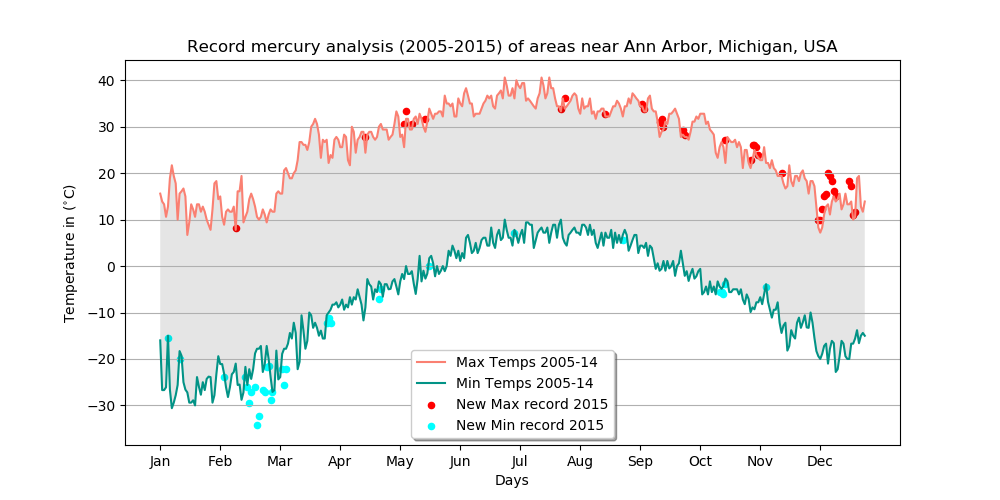

In [14]:
%matplotlib notebook

plt.figure(figsize=(10,5))

#https://matplotlib.org/tutorials/colors/colors.html
max_org,=plt.plot(weather_df_records['TMAX'].tolist(),'salmon', label='2005-14 Record Max')
min_org,=plt.plot(weather_df_records['TMIN'].tolist(),'xkcd:teal', label='2005-14 Record Min')

#Create scatter plot for days in 2015 that broke the record high or low when compared to data from 2005-14
for index, row in weather_df_2015_records.iterrows():
    if row['TMIN'] < weather_df_records.loc[index,'TMIN']:
        min_rec=plt.scatter(index, row['TMIN'], s=20, c = 'aqua') 
        
for index, row in weather_df_2015_records.iterrows():
    if row['TMAX'] > weather_df_records.loc[index,'TMAX']:
        max_rec=plt.scatter(index, row['TMAX'], s=20, c = 'red')

In [15]:
#Add a legend
plt.legend((max_org,min_org,max_rec,min_rec),
           ('Max Temps 2005-14','Min Temps 2005-14','New Max record 2015', 'New Min record 2015'),scatterpoints=1,
           loc='lower center',shadow=True)

#Lable the axes and give the figure a title
plt.xlabel('Days')
plt.ylabel('Temperature in $(^{\circ}$C) ')
plt.title('Record mercury analysis (2005-2015) of areas near Ann Arbor, Michigan, USA')

#mark the area between record highs and lows
plt.gca().fill_between(range(len(weather_df_records['TMAX'].tolist())),
                       weather_df_records['TMAX'].tolist(), weather_df_records['TMIN'].tolist(),
                       facecolor='black', 
                       alpha=0.10)
plt.grid(axis='y')

In [16]:
months_df=list(weather_df_2015_records['Month'].unique())
months_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

plt.gca().set_xticks(np.arange(0,365,31))
ticks = []

for mon in months_df:
    try:
        ticks.append(months_dict[mon])
    except KeyError:
        ticks.append('')

plt.gca().set_xticklabels(ticks)

[Text(-50.0, 0, 'Jan'),
 Text(0.0, 0, 'Feb'),
 Text(50.0, 0, 'Mar'),
 Text(100.0, 0, 'Apr'),
 Text(150.0, 0, 'May'),
 Text(200.0, 0, 'Jun'),
 Text(250.0, 0, 'Jul'),
 Text(300.0, 0, 'Aug'),
 Text(350.0, 0, 'Sep'),
 Text(400.0, 0, 'Oct'),
 Text(0, 0, 'Nov'),
 Text(0, 0, 'Dec')]